Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Manuela Bastidas Olivares y Nicolás Guarín-Zapata 2024.

# Solucion de la ecuación de Poisson usando PINNs

## Descripción del problema

Queremos resolver la siguiente ecuación

$$ \frac{d^2 u(x)}{d^2 x}  = f(x)\quad \forall x \in (0, 1)$$

con $u(0) = u(1) = 0$.


In [1]:
# Esto permite tener gráficos interactivos en
# el caso de correrse en Google Colab
if 'google.colab' in str(get_ipython()):
    %pip install ipympl
    from google.colab import output
    output.enable_custom_widget_manager()

In [2]:
%matplotlib widget

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

In [4]:
if 'google.colab' in str(get_ipython()):
    style = "https://raw.githubusercontent.com/nicoguaro/pinns_mapi-3/main/notebooks/clean.mplstyle"
else:
    style = "./clean.mplstyle"
plt.style.use(style)

In [5]:
class Model(torch.nn.Module):
    def __init__(self, neurons, n_layers, activation=torch.tanh):
        super(Model, self).__init__()
        self.activation = activation
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(1, neurons))
        for _ in range(n_layers-2):
            self.layers.append(torch.nn.Linear(neurons, neurons))
        self.layers.append(torch.nn.Linear(neurons, 1))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x


In [6]:
def f_rhs(x):
    return -1

def loss_fn(u_model, x, f):
    u = u_model(x)
    du = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du = (1 + 0.5 * u) * du
    ddu = grad(du, x, grad_outputs=torch.ones_like(du), create_graph=True)[0]
    error_PDE = torch.mean((ddu - f(x))**2)
    bc = u_model(torch.tensor([1.]))**2 + u_model(torch.tensor([0.]))**2
    return error_PDE + bc[0]

def train(model, optimizer, loss_fn, f, n_pts, iterations):
    losses = []
    for iteration in range(iterations):  
        optimizer.zero_grad()
        x = torch.FloatTensor(n_pts,1).uniform_(0, 1).requires_grad_(True)
        loss = loss_fn(model, x, f)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if iteration % 1000 == 0:
            print(f'Iteration {iteration}, Loss {loss.item()}')
    return losses

def exact_u(x):
    eps = 0.5
    u0 = -0.5 * x * (x - 1)
    u1 = u0**2/4
    return u0 - eps * u1


In [7]:
nn = 10
nl = 4
n_pts = 1000
iterations = 1000

model = Model(neurons=nn, n_layers=nl)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = train(model, optimizer, loss_fn, f_rhs, n_pts, iterations)

Iteration 0, Loss 1.198171854019165


In [8]:
xlist = np.array([1/1000 * i for i in range(1000)])
xlist_torch = torch.tensor(xlist, dtype=torch.float32).view(-1, 1)

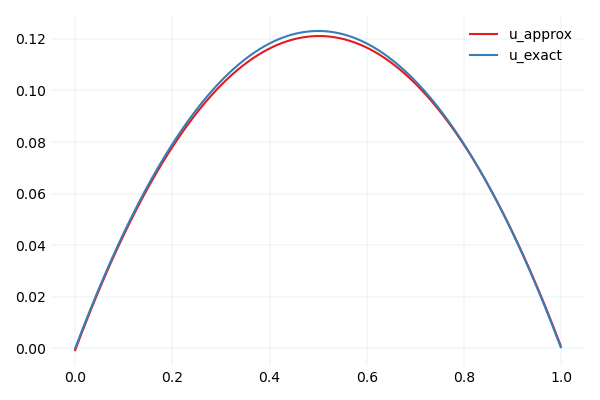

In [9]:
fig, ax = plt.subplots()
plt.plot(xlist, model(xlist_torch).detach().numpy())
plt.plot(xlist, exact_u(xlist_torch).detach().numpy())
plt.legend(['u_approx', 'u_exact'])
plt.tight_layout()

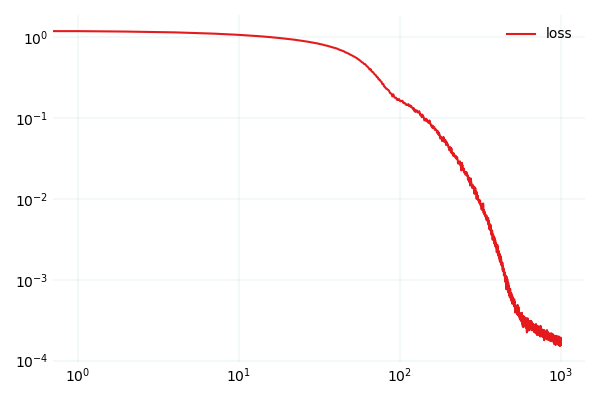

In [10]:
fig, ax = plt.subplots()
plt.loglog(losses)
plt.legend(['loss'])
plt.tight_layout()